$$
\left\{ \begin{align*}
         \frac{dx}{dt} &= (y-x^3 - x)/\epsilon, \\		   
		\frac{dy}{dt} &= a - x \end{align*} \right.
		\qquad
$$

In [1]:
import PyDSTool as dst
from PyDSTool import args
import numpy as np
from matplotlib import pyplot as plt

pars = {'Droop': 0.05, 
        'H': 4.5, 
        'Damp': 1.0,
        'K_d': 0.0,
        'T_d': 0.01,
          'K_f':0.00,
          'K_w1':100.0,
          'T_w1':5.0,
      }
icdict = {'Df': 0.0,
          'p_g': 0.0,
          'e_nc':10.0,
          'Dfp':0.0,
          'p_nc':0.0,
          'wo1':0.0}

dDf  = '1.0/(2.0*H)*(p_g + p_nc - 0.2 - Damp*Df)'
dp_g = '1.0/3.0*(-1.0/Droop*Df - p_g)'
dDfp = '1.0/T_d*(Df - Dfp)'
#dp_nc = '1.0/0.01*(-K_d*df(Df,Dfp)-K_f*Df)'
dp_nc = '1.0/0.01*(if(p_nc_ref(Df,Dfp,wo1)>0.1,0.1,p_nc_ref(Df,Dfp,wo1))-p_nc)'
de_nc= '-p_nc'
df = '1.0/0.01*(Df-Dfp)'
dwo1 = '1.0/T_w1*(Df-wo1)'
dfwo1 = '1.0/T_w1*(Df-wo1)'
p_nc_ref = '-K_d*df(Df,Dfp)-K_w1*dfwo1(Df,wo1)'
# auxiliary helper function(s) -- function name: ([func signature], definition)

DSargs = args(name='sys_freq_1')  # struct-like data
DSargs.pars = pars
DSargs.tdata = [0, 15]
DSargs.fnspecs  = {'df': (['Df','Dfp'], df),
                   'dfwo1': (['Df','wo1'], dfwo1),
                   'p_nc_ref': (['Df','Dfp','wo1'], p_nc_ref)}

DSargs.algparams = {'max_pts': 1000, 'init_step': 0.02, 'stiff': True}

DSargs.varspecs = {'Df': dDf, 
                   'p_g': dp_g, 
                   'e_nc':de_nc, 
                   'p_nc': dp_nc, 
                   'Dfp':dDfp,
                   'wo1': dwo1}

#DSargs.xdomain = {'x': [-2.2, 2.5], 'y': [-2, 2]}
DSargs.ics = icdict
sys = dst.Vode_ODEsystem(DSargs)

0.0881505012512207 -0.0177326429995


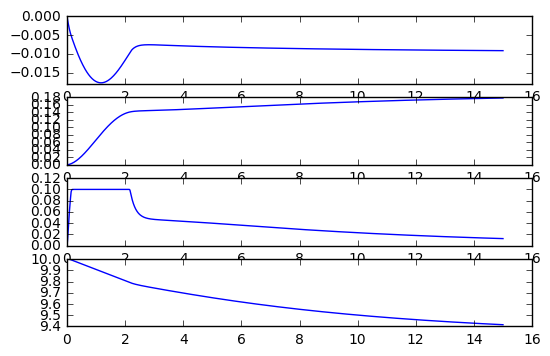

In [2]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4)   # creates a figure with one axe
import time 
for H in [2]:
    t_0 = time.time()
    sys.pars['H'] = H
    traj = sys.compute('test_traj')
    pts = traj.sample()
    f_min = np.min(pts['Df'])
    print(time.time()-t_0, f_min)


    ax0.plot(pts['t'], pts['Df']) 
    ax1.plot(pts['t'], pts['p_g']) 
    ax2.plot(pts['t'], pts['p_nc']) 
    ax3.plot(pts['t'], pts['e_nc']) 
plt.show()




In [3]:
from IPython.display import display, clear_output
import sys as ssys
from pyswarm import pso

def obj(x):
    sys.pars['K_w1'] = x
    pts = sys.compute('test_traj').sample()
    f_min = np.min(pts['Df'])
    #clear_output(wait=True)
    #print(pts['e_nc'][-1]-9)
    #ssys.stdout.flush()    
    return -f_min

def con(x):
    pts = sys.compute('test_traj').sample()
    return pts['e_nc'][-1]-9.5

lb = [10]
ub = [500]

print(obj(11))
xopt, fopt = pso(obj, lb, ub, f_ieqcons=con, args=(), kwargs={},
    swarmsize=10, omega=0.5, phip=0.5, phig=0.5, maxiter=100, minstep=1e-8,
    minfunc=0.1, debug=False)


# Optimum should be around x=[0.5, 0.76] with banana(x)=4.5 and con(x)=0
pts = sys.compute('test_traj').sample()
print(sys.pars['K_w1'])
print(pts['e_nc'][-1])
print(np.min(pts['Df']))

0.0272548145389
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
[ 172.62254576]
9.24488200232
-0.0176487156055


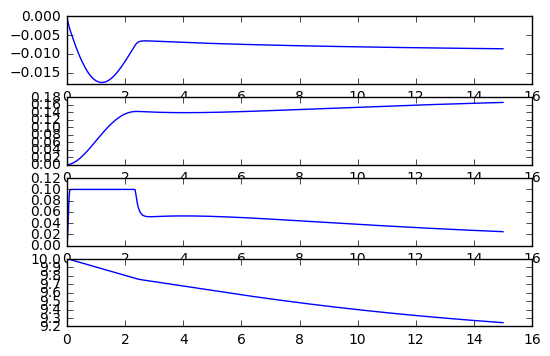

In [4]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4)   # creates a figure with one axe
ax0.plot(pts['t'], pts['Df']) 
ax1.plot(pts['t'], pts['p_g']) 
ax2.plot(pts['t'], pts['p_nc']) 
ax3.plot(pts['t'], pts['e_nc']) 
plt.show()


In [5]:
from IPython.display import display, clear_output
import sys as ssys
from pyswarm import pso

def obj(x):
    sys.pars['K_d'] = x[0]
    sys.pars['K_w1'] = x[1]
    pts = sys.compute('test_traj').sample()
    f_min = np.min(pts['Df'])
    #clear_output(wait=True)
    #print(pts['e_nc'][-1]-9)
    #ssys.stdout.flush()    
    return -f_min

def con(x):
    pts = sys.compute('test_traj').sample()

    e = np.min(pts['e_nc'])-9.5
    clear_output(wait=True)
    print(e)
    ssys.stdout.flush()  
    return e

lb = [-10,0]
ub = [100,200]


xopt, fopt = pso(obj, lb, ub, f_ieqcons=con, args=(), kwargs={},
    swarmsize=10, omega=0.5, phip=0.5, phig=0.5, maxiter=100, minstep=1e-8,
    minfunc=0.1, debug=False)


# Optimum should be around x=[0.5, 0.76] with banana(x)=4.5 and con(x)=0
pts = sys.compute('test_traj').sample()
print('K_d',sys.pars['K_d'])
print('K_w1',sys.pars['K_w1'])
print('e_nc', pts['e_nc'][-1])
print('min Df',np.min(pts['Df']))



0.289581387148
Stopping search: Swarm best objective change less than 0.1
K_d 83.3044750319
K_w1 97.2486098533
e_nc 9.926906549
min Df -0.0176010811467


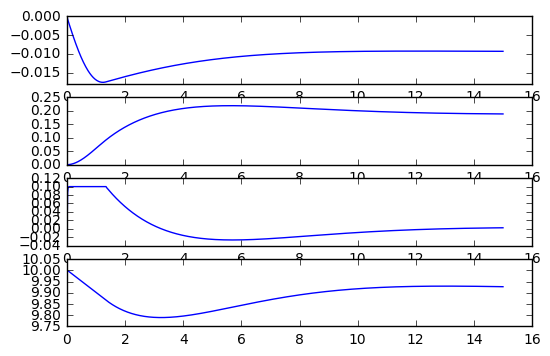

In [6]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4)   # creates a figure with one axe
ax0.plot(pts['t'], pts['Df']) 
ax1.plot(pts['t'], pts['p_g']) 
ax2.plot(pts['t'], pts['p_nc']) 
ax3.plot(pts['t'], pts['e_nc']) 
plt.show()
